In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
#use_python("/home/vsevim/software/anaconda3/envs/R42/bin/python")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    # data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"

    # prj_name = "Screen2_101vecs"
    # # data_subdir_suffixes = "L1,L2,L3,L4"     
    # secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    # save_seurat_h5 = "NO"

}


In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated_wo_guide_calls.h5seurat")
updated_integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated.h5seurat")
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Use only singlets (actually I didn't include the singlets in the integrated file, so this step is unnecessary)

In [6]:
seurat_combined <- subset(seurat_combined, subset = status == 'singlet')

# Call all guides

Skipping guides with less than 50 counts
Running Lib_1 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE6-2b 39 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_1 
Running Lib_2 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_2 
Running Lib_3 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_3 


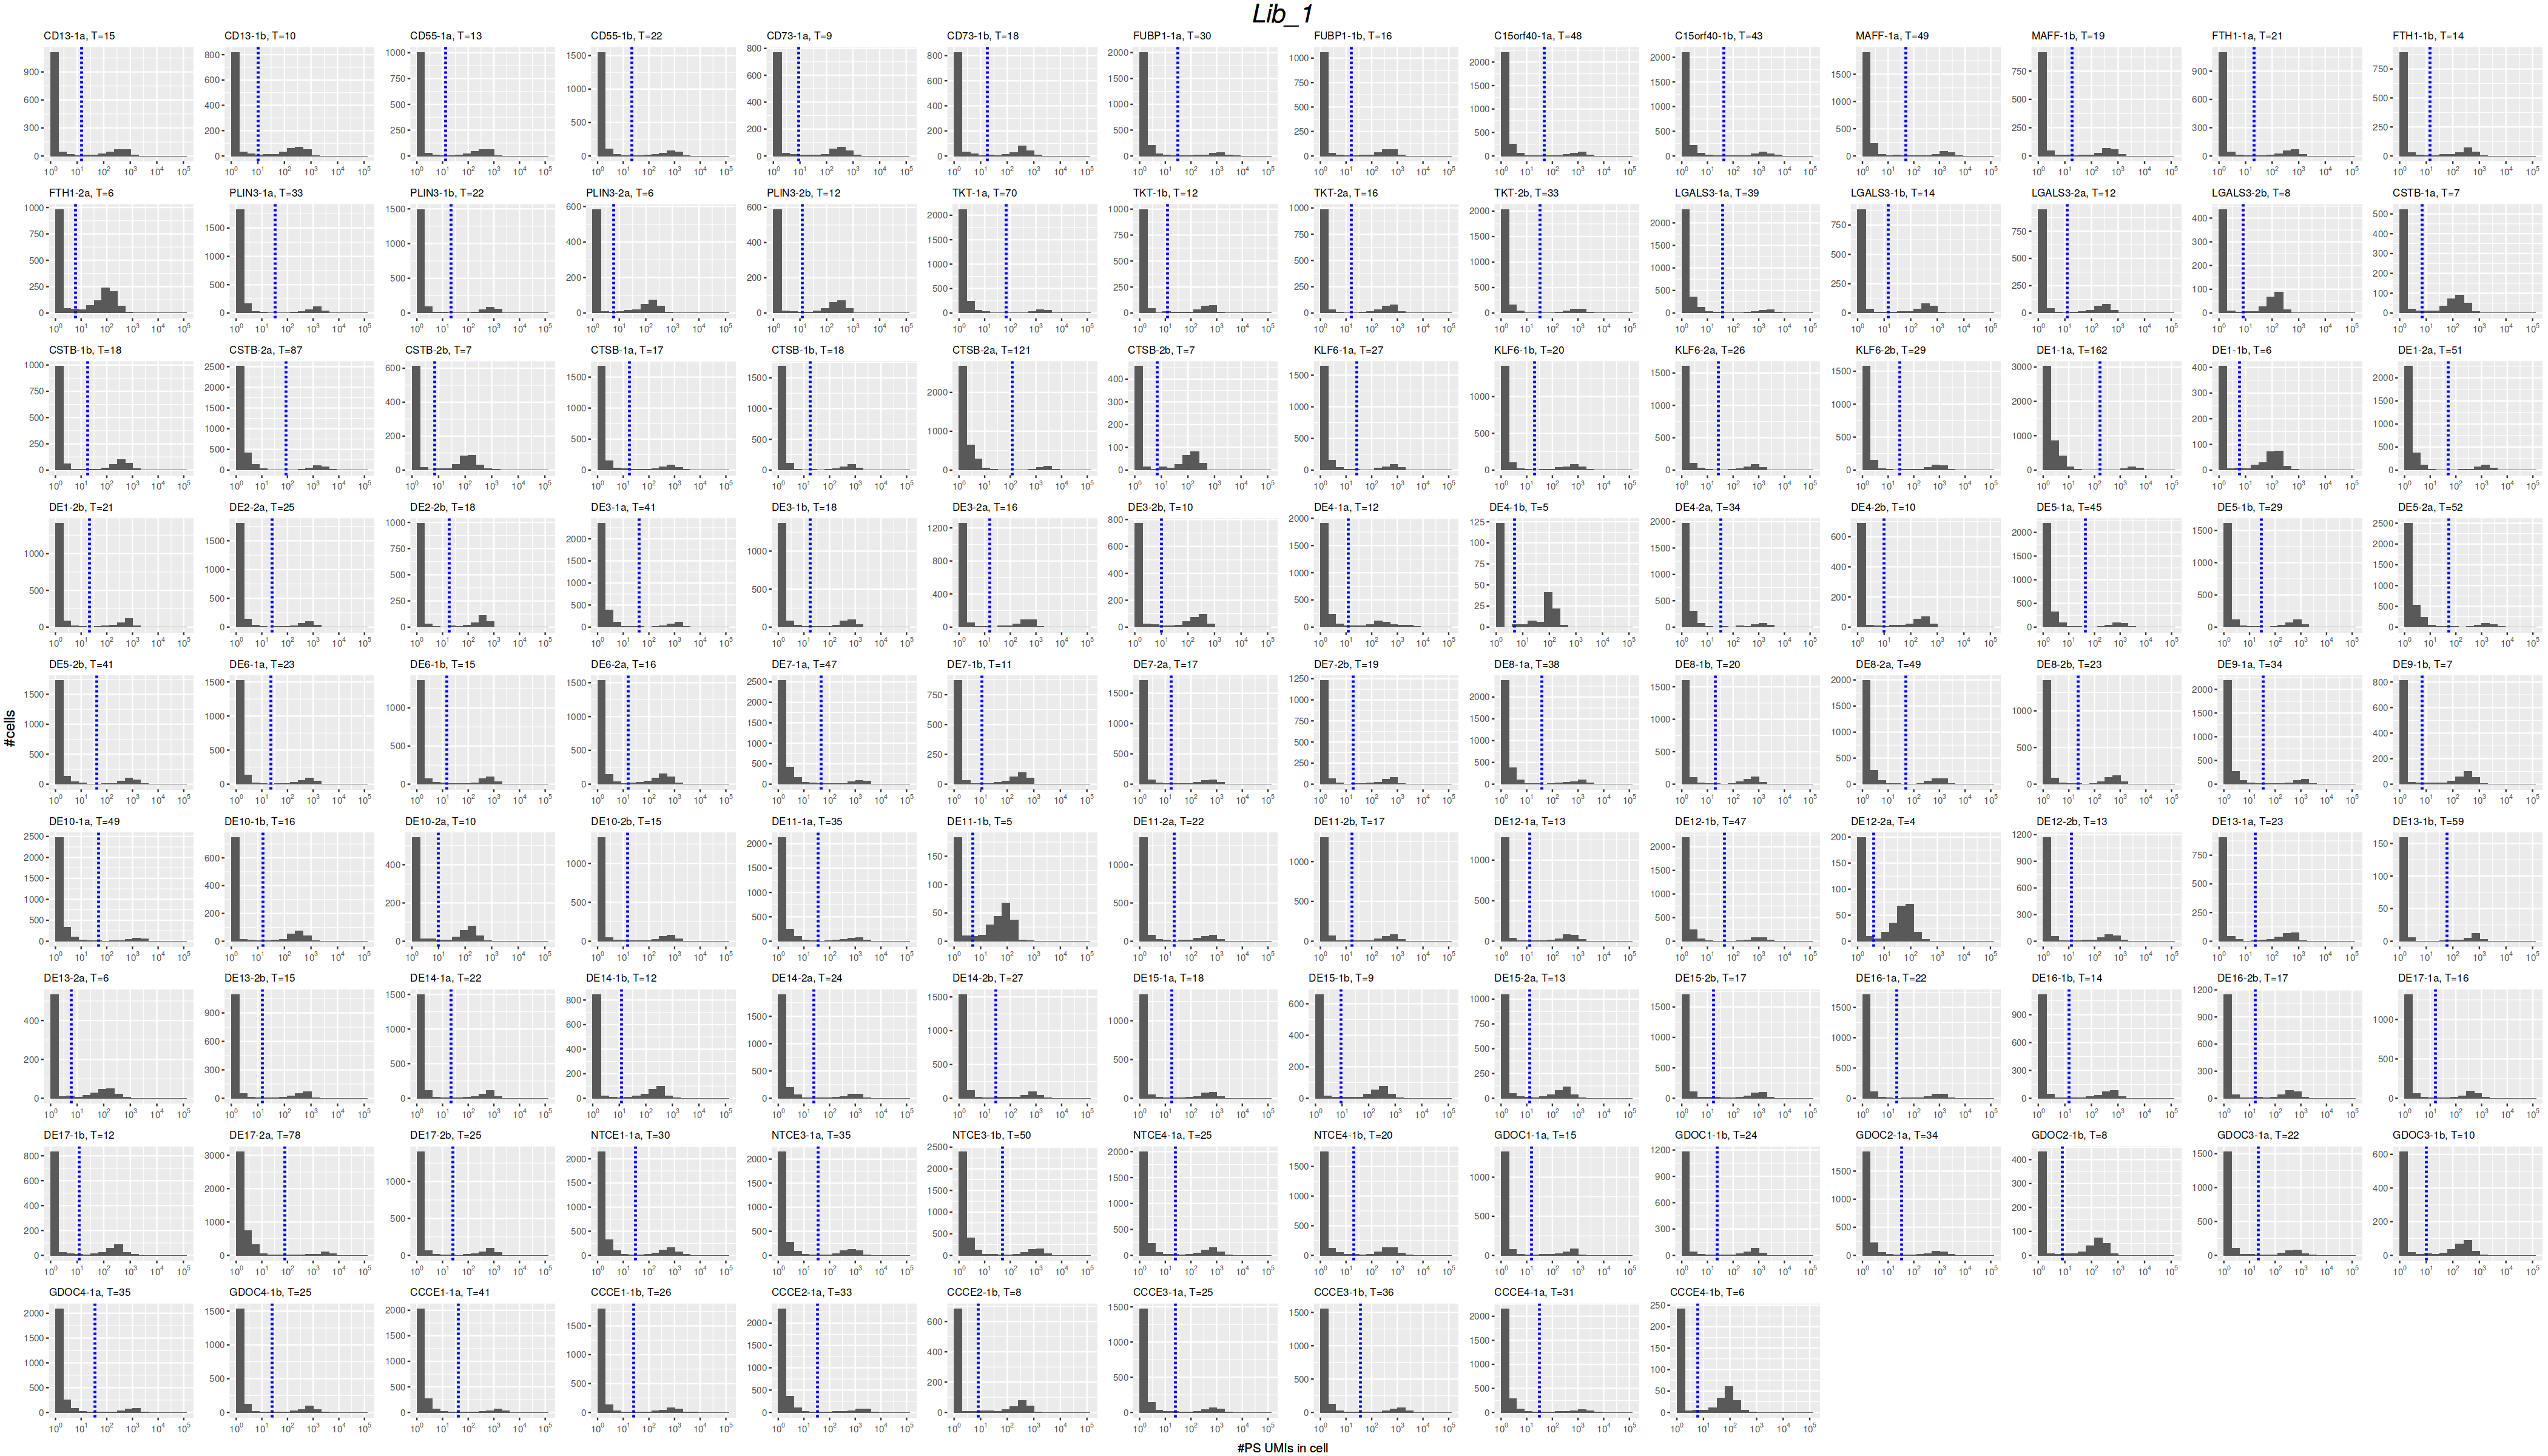

Running Lib_4 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 1 guides found
Skipping DE2-1b 1 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_4 


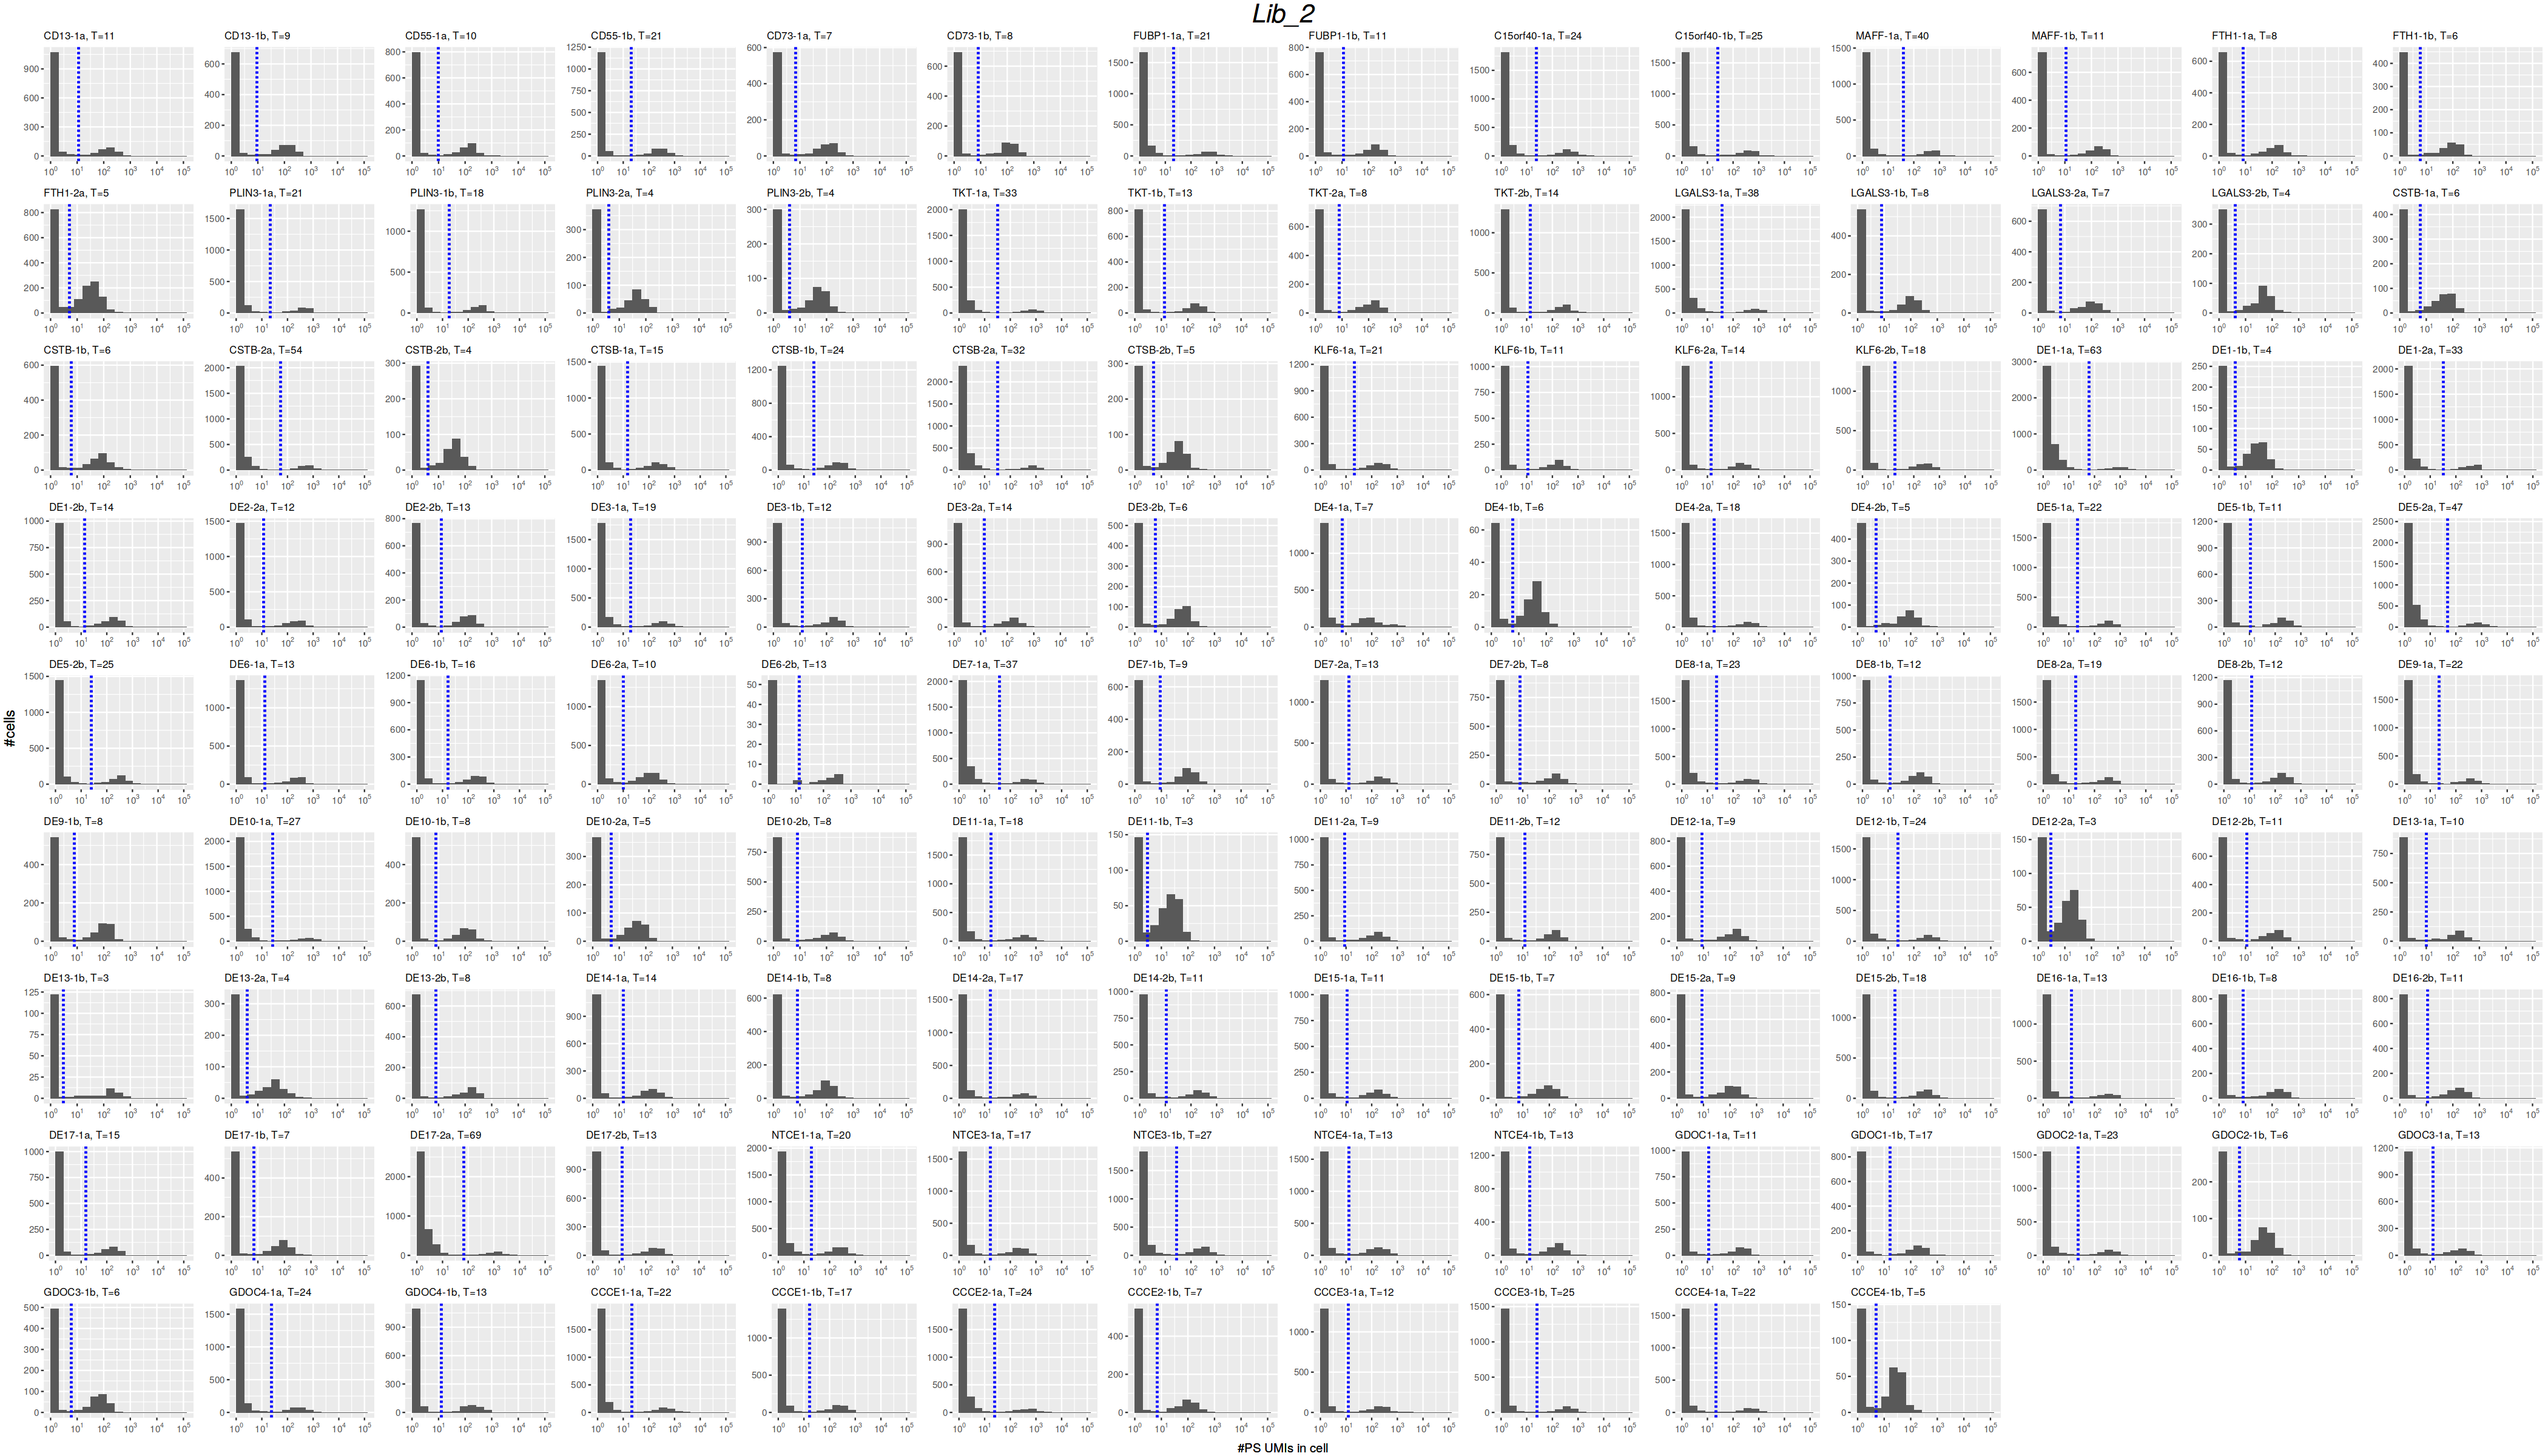

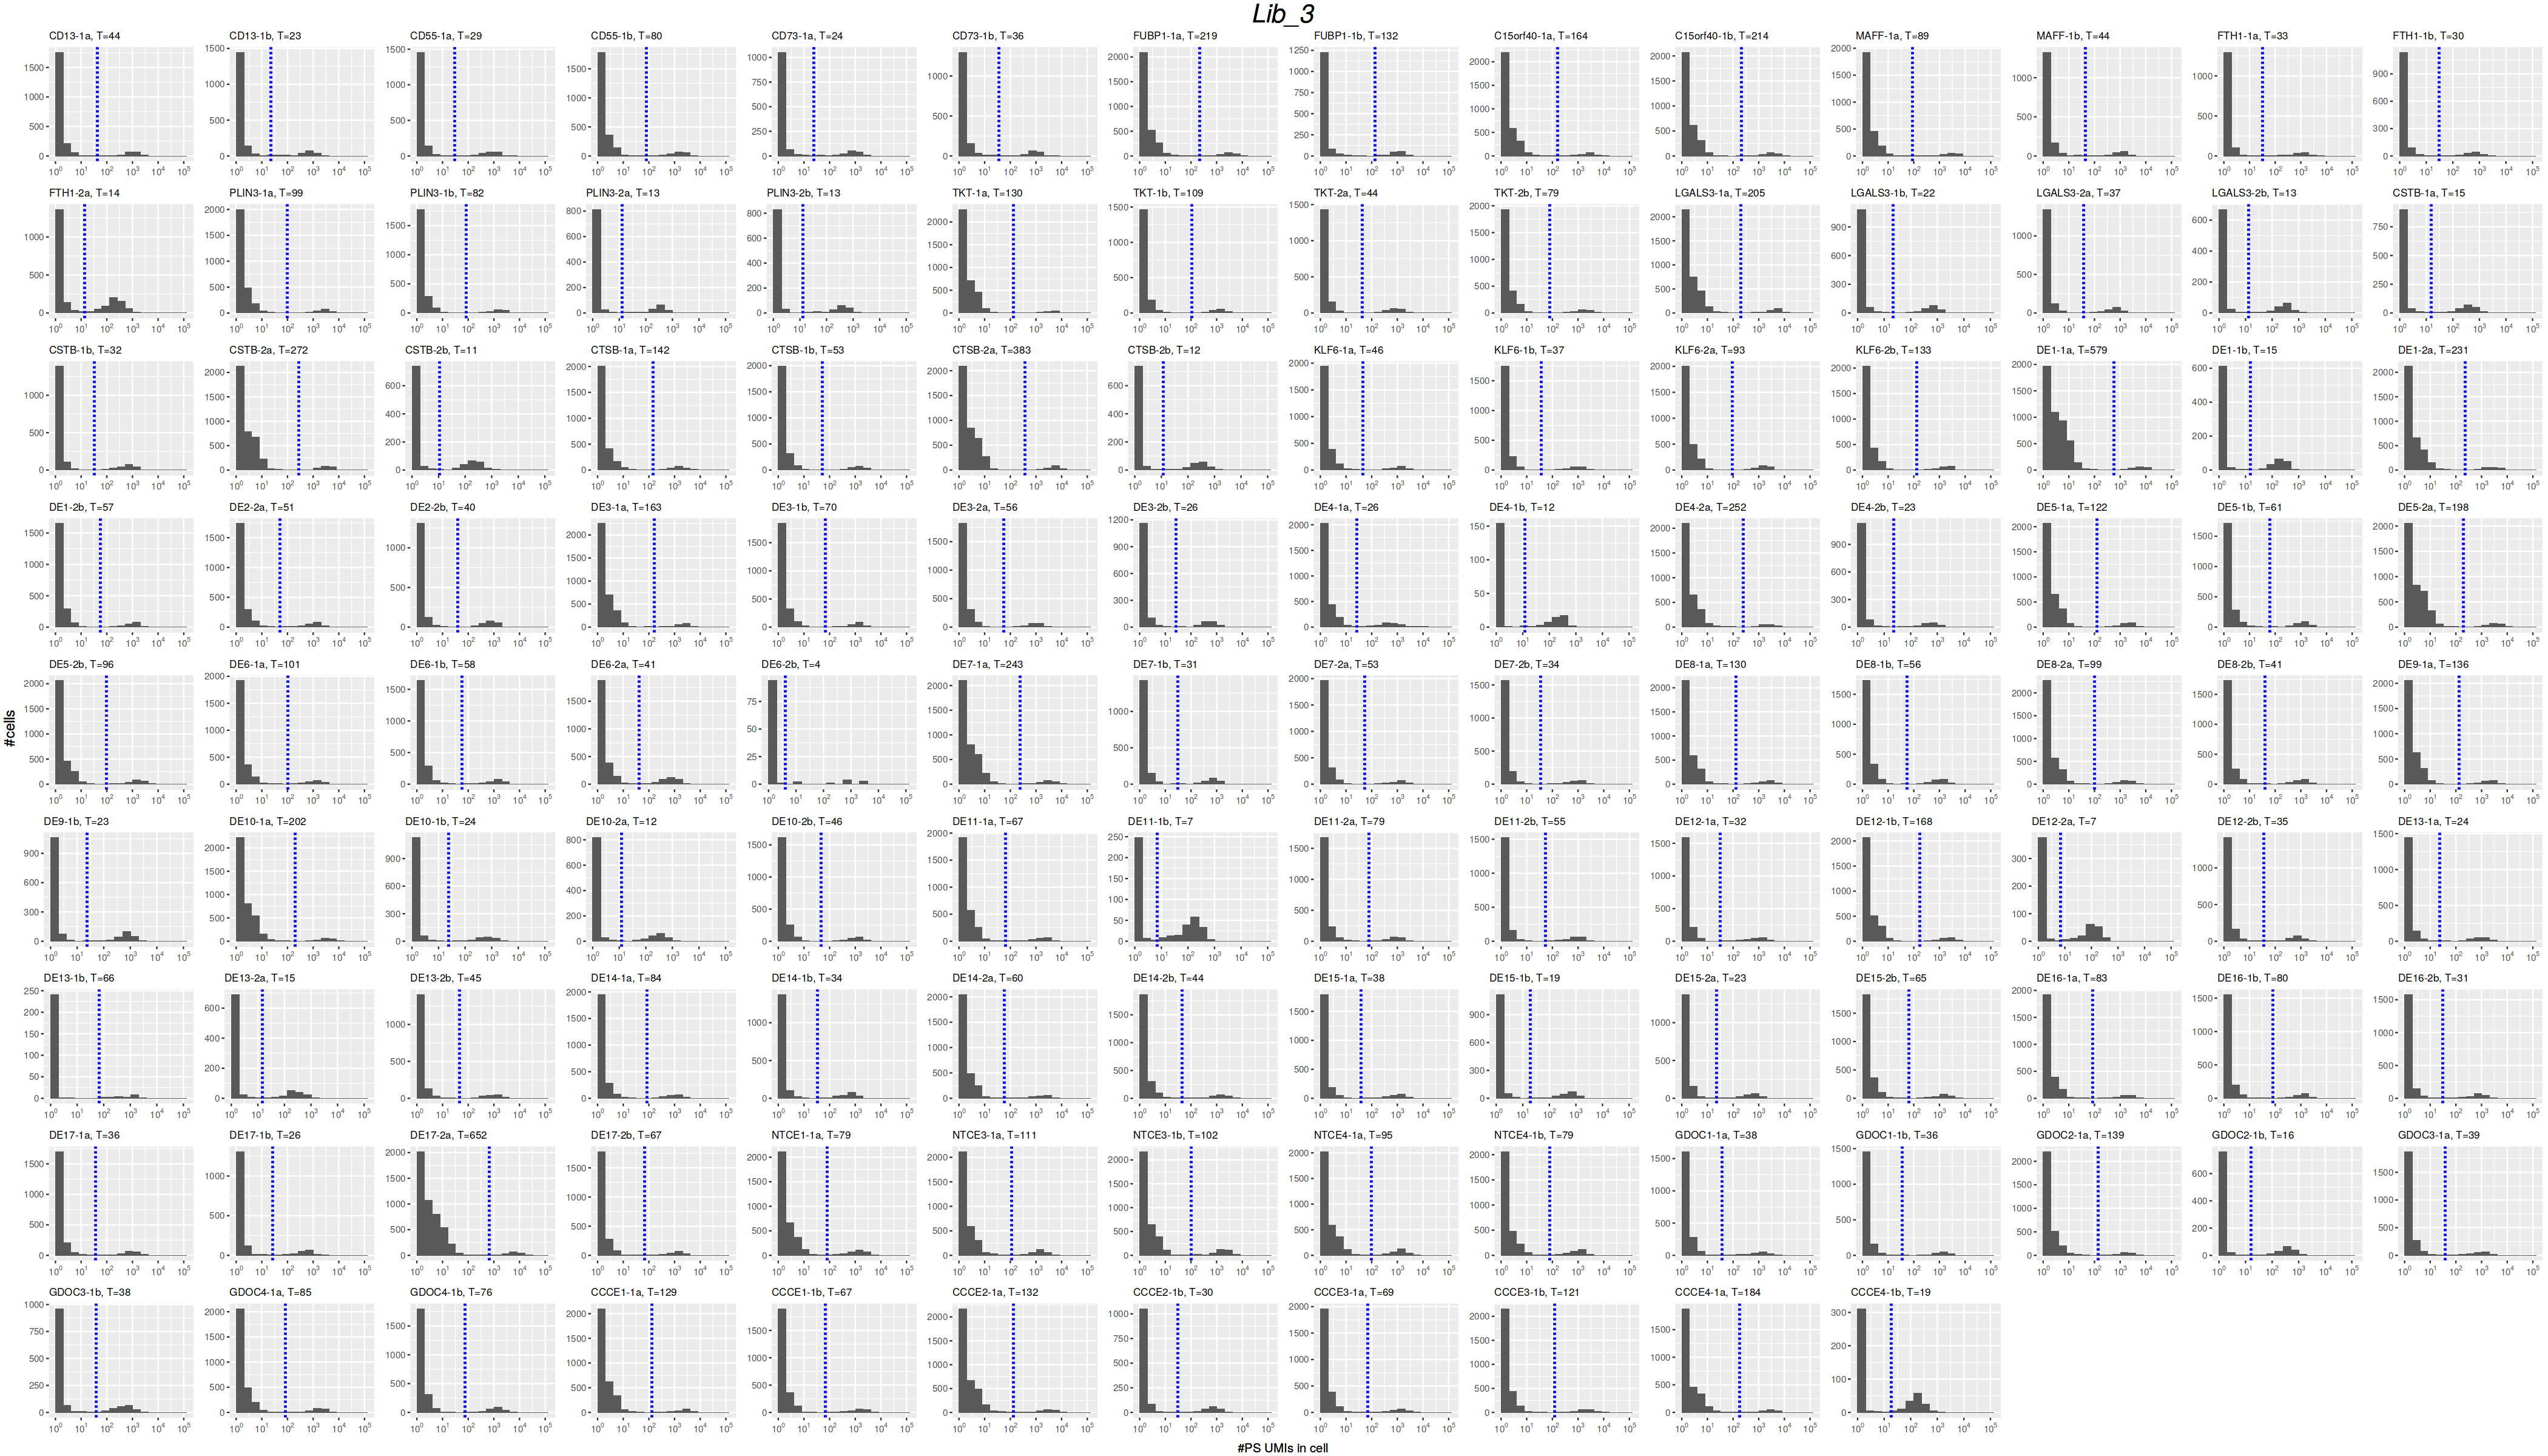

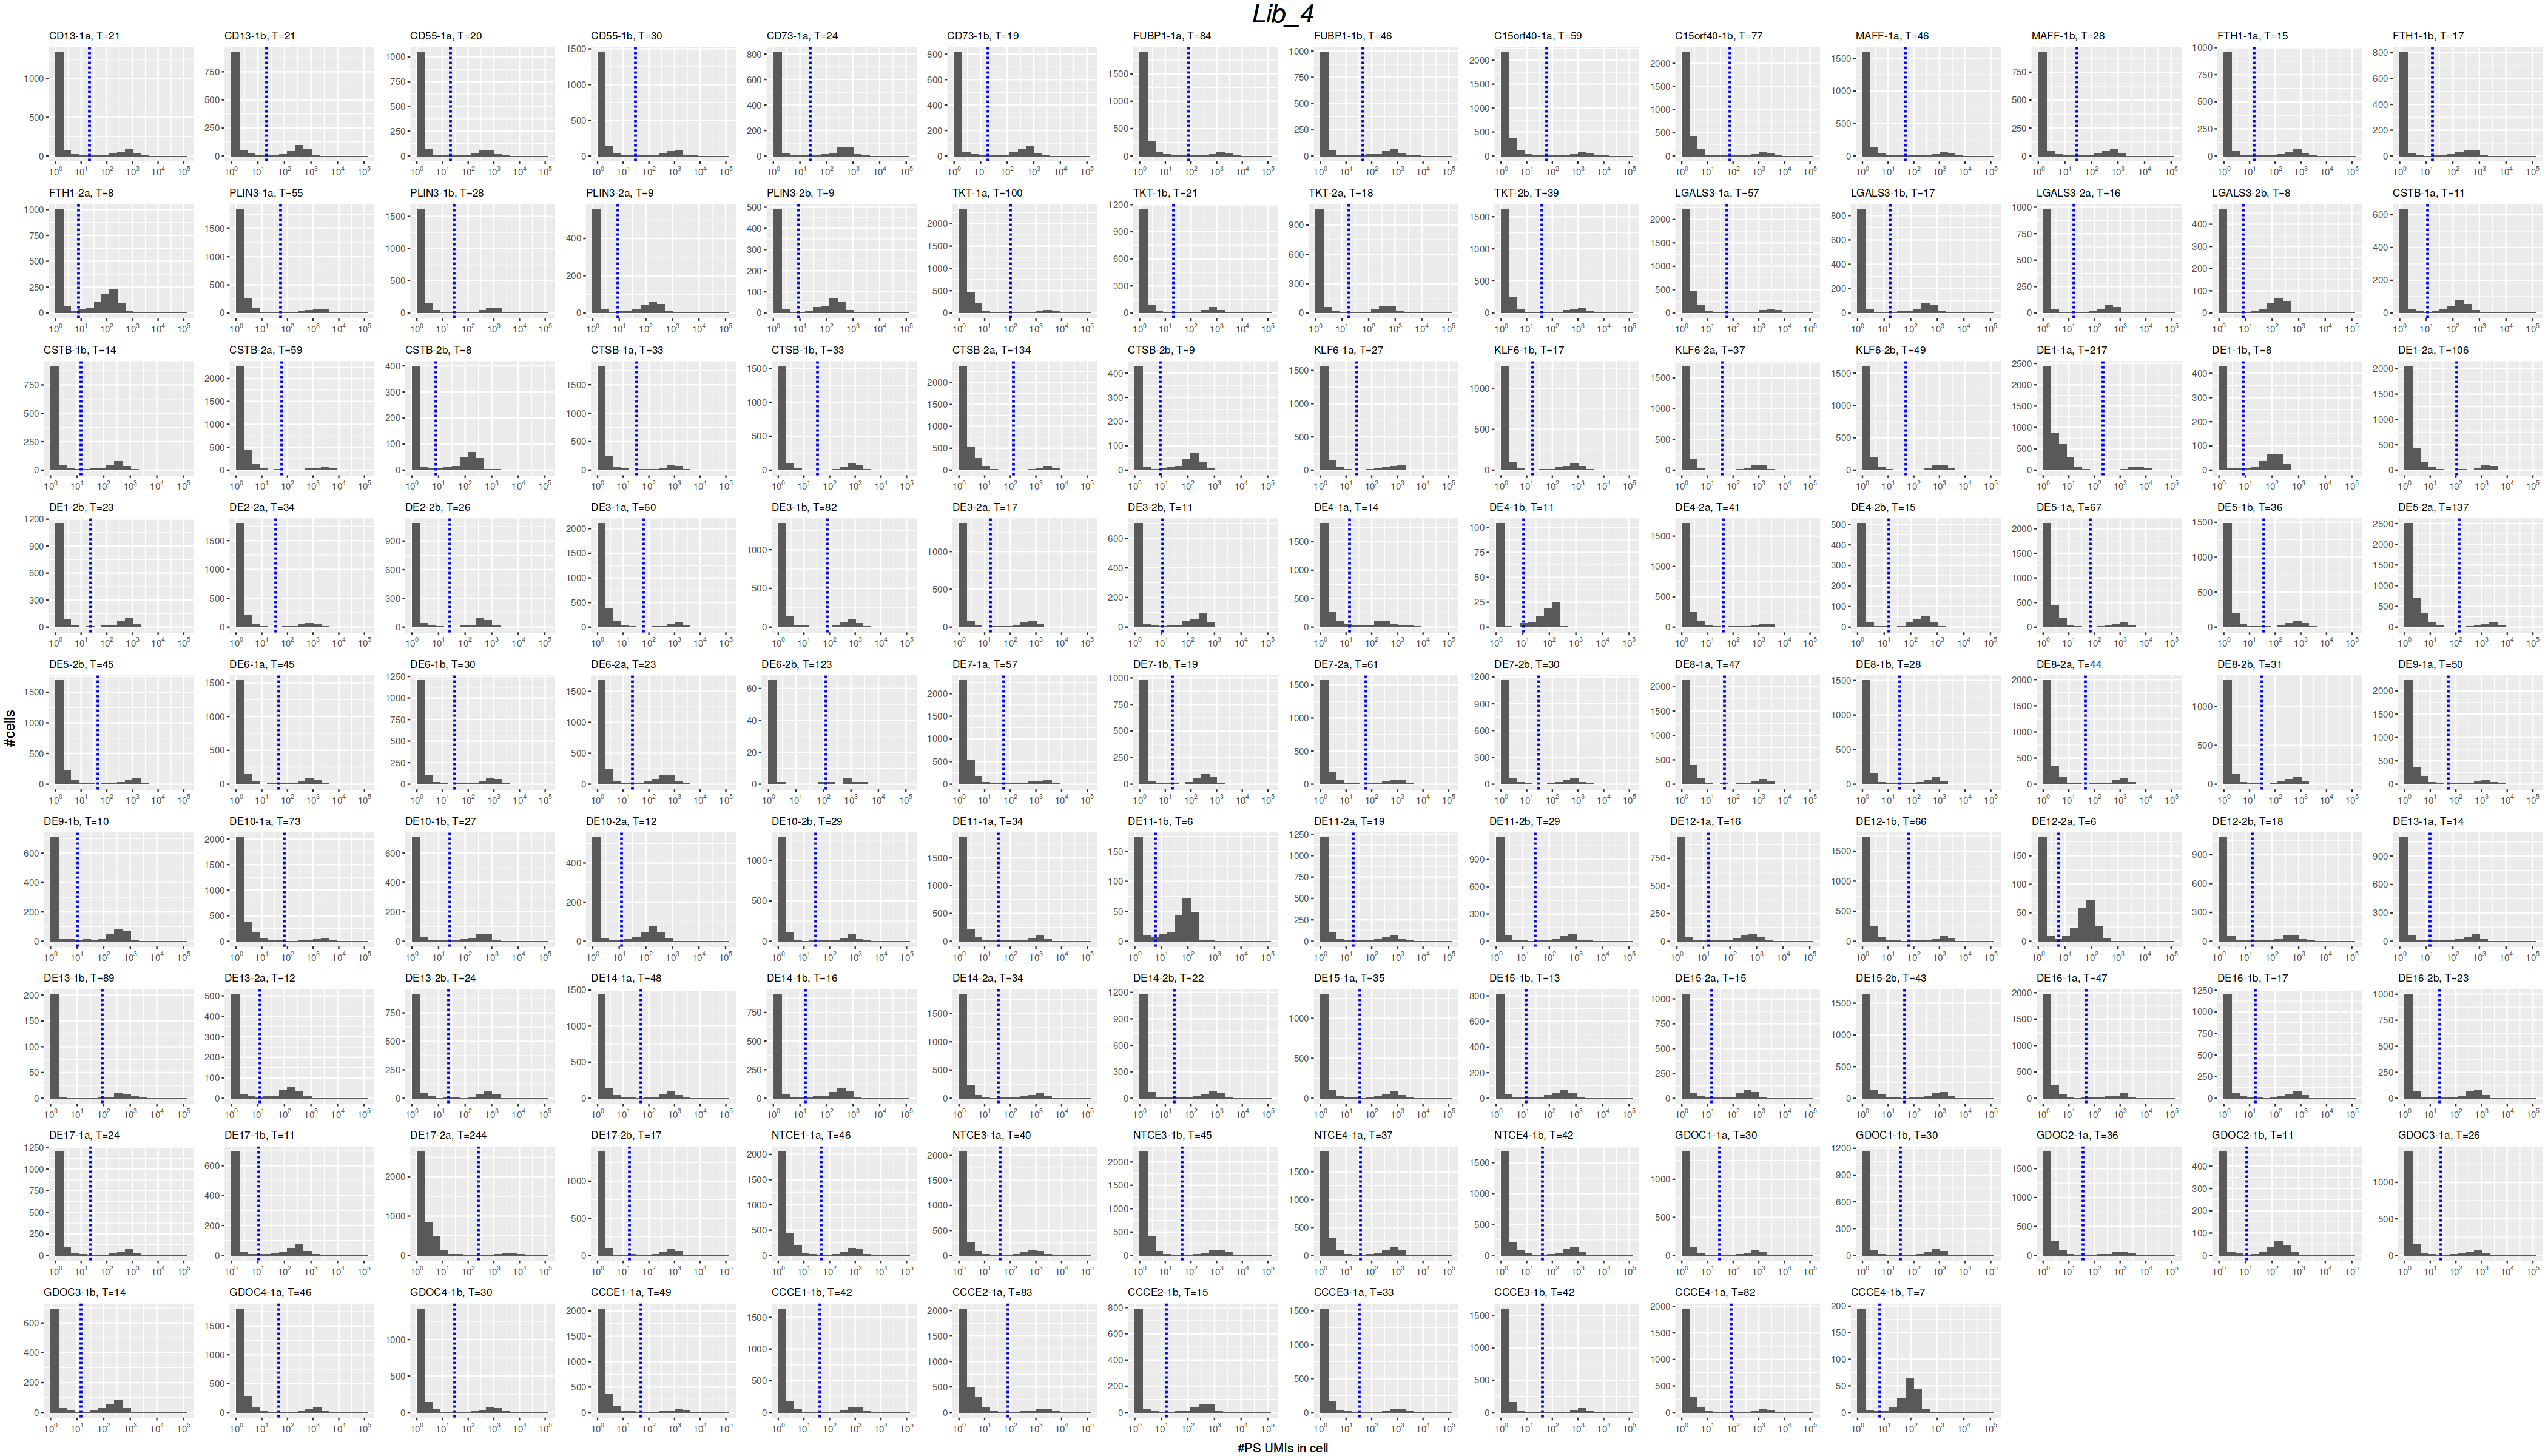

In [7]:
libraries = unique(seurat_combined$library)
min_guide_count = 50
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for(l in seq_along(libraries)){
    # subset 
    library_name = libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat  <- subset(seurat_combined, subset = library == library_name)

    DefaultAssay(seurat) <- "sgRNA"
    df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
    rownames(df_guide_counts) <- NULL

    CUTOFF_PROB = 0.5
    guides = colnames(df_guide_counts)
    plots = list()

    for(i in seq_along(guides)) {
        guide = guides[[i]]
        y = df_guide_counts[,guide]
        select_nonzeros = y > 0
        y = y[select_nonzeros]
        index = nrow(df_thresholds) + 1
        if(length(y) <= min_guide_count) {
            cat("Skipping", guide, length(y), "guides found\n")
            df_thresholds[index,] <-  c(library_name, guide, NA)
            next
        }
        
        calls <- pgmix(y)
        df_calls = as.data.frame(calls)
        df_calls['counts'] = y
        colnames(df_calls) = c('call', 'prob', 'count')
        options(repr.plot.width=4, repr.plot.height=4)
        head(df_calls)
        dim(df_calls)
        select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB

        df_gauss = df_calls[select_gaussian_assigned,]
        dim(df_gauss)
        
        # head(df_gauss)
        threshold = min(df_gauss$count)
        #cat("threshold=", threshold)
        filter_y = y > 0
        y_filtered = y[filter_y]
        df_y = as.data.frame(y_filtered)
        head(df_y)
        
        options(repr.plot.width=3.3, repr.plot.height=2.4)
        bin_breaks <- c(1,2,2*2^(1:16))
        title = paste0(guide, ", T=", threshold)

        ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
            labs(title=title, x=NULL, y=NULL) +  
            geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
            theme(plot.title = element_text(size=10))

        plots <- append(plots, list(ggp1))
        #index = nrow(df_thresholds) + 1
        df_thresholds[index,] <-  c(library_name, guide, threshold)
    }
    cat(green("Completed", library_name, "\n"))
    flush.console()
    options(repr.plot.width=35, repr.plot.height=20)
    plt <- gridExtra::grid.arrange(
        grobs = plots, 
        ncol = 14, 
        bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
        left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
        top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
    )
    grid::grid.draw(plt)
    pdf_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/guide_distr/"
    ggsave(
        file = paste0(pdf_path, library_name, "_guide_distributions.pdf"), 
        plt,
        width = 22, 
        height = 17, 
        dpi = 300
    )
}

# Write thresholds to file

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
head(df_thresholds)

if(save_seurat_h5 == "YES") {
    write.table(df_thresholds, thr_f_name, sep="\t", quote = F, row.names = F)
}

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,15
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,13
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,9
6,Lib_1,CD73-1b,18


In [9]:
head(df_thresholds)

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,15
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,13
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,9
6,Lib_1,CD73-1b,18


In [10]:
#head(seurat_combined@misc$stats)
rownames(seurat_combined@misc$stats) <- seurat_combined@misc$stats$Library

In [11]:
#head(seurat_combined)

In [12]:
nrow(seurat_combined@meta.data[seurat_combined@meta.data$library == 'Lib_1', ])
seurat  <- subset(seurat_combined, subset = library == 'Lib_1')
#DefaultAssay(seurat) <- "sgRNA"
nrow(seurat@meta.data)



[1] 7293

[1] 7293

# Update the Seurat object with Poission-Gaussian calls 

### Load thresholds

In [13]:
### Load THRESHOLDS.tsv
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)
### Load guide df
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting,CD55,Control TSS
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting,NT5E,Control TSS
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting,FUBP1,Control TSS
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting,MAFF,Control TSS


### Get the list of pertubed cells for each guide

In [14]:
perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds)

In [15]:
df_calls = enframe(perturbed_cells_by_guide) %>% unnest(2)
df_calls = as.data.frame(df_calls)
df_calls$guide <- as.character(df_calls$name)
df_calls$cell  <- as.character(df_calls$value)
df_calls$name <- NULL
df_calls$value <- NULL
df_calls$plasmid <- sub(".$", "", df_calls$guide)

In [16]:
df_calls_wide <- df_calls %>% 
    group_by(cell) %>% 
    summarise(
        guide_calls = paste(unique(guide), collapse = '|'), 
        plasmid_calls = paste(unique(plasmid), collapse = '|')
    )

In [17]:
df_calls_wide$n_guides   <- str_count(df_calls_wide$guide_calls, "\\|") + 1
df_calls_wide$n_plasmids <- str_count(df_calls_wide$plasmid_calls, "\\|") + 1
df_calls_wide = as.data.frame(df_calls_wide)
rownames(df_calls_wide) <- df_calls_wide$cell
df_calls_wide$cell <- NULL

In [18]:
head(df_calls_wide,2)

,guide_calls,plasmid_calls,n_guides,n_plasmids
,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGAGGTCAC-1_3,DE14-2b|NTCE1-1a|GDOC4-1a,DE14-2|NTCE1-1|GDOC4-1,3,3


### Update the Seurat object with Poisson-Gaussian guide calls

Update the Seurat object

In [19]:
seurat_backup = seurat_combined
#seurat_combined = seurat_backup

In [21]:
cols2rename = c('PS_call', 'construct_call', 'target_call', 'nCalled_Constructs', 'nPS_calls', 'nCalled_sgRNA_UMIs')
df_dummy = seurat_combined@meta.data
for(i in 1:length(cols2rename)) {
    colname = cols2rename[i]
    names(df_dummy)[names(df_dummy) == colname] <- paste0('cellranger_', colname) 
}

#### Merge calls with the Seurat object

In [22]:
df_dummy = merge(df_dummy, df_calls_wide, by = 0, all.x = T)
rownames(df_dummy) <- df_dummy$Row.names
df_dummy$Row.names <- NULL
original_row_names <- rownames(seurat_combined@meta.data)
seurat_combined@meta.data = df_dummy[original_row_names,]

In [23]:
select_na = is.na(seurat_combined$n_plasmids)
seurat_combined$n_plasmids[select_na] = 0
seurat_combined$n_guides[select_na] = 0

In [24]:
nrow(seurat_backup@meta.data)
nrow(seurat_combined@meta.data)
nrow(df_dummy)

[1] 27141

[1] 27141

[1] 27141

In [29]:
is.na(seurat_combined@meta.data[5,]$guide_calls)

[1] TRUE

How many cells with no calls?

In [30]:
sum(seurat_combined$n_plasmids == 0)

[1] 6380

In [31]:
sum(rownames(seurat_combined) != rownames(seurat_backup))

[1] 0

In [32]:
nrow(df_calls_wide)
length(Cells(seurat_combined))

[1] 20761

[1] 27141

No-call cells are really not in df_calls_wide?

In [33]:
no_call_cells = rownames(seurat_combined@meta.data[seurat_combined$n_plasmids == 0, ])
intersect(rownames(df_calls_wide), no_call_cells)

character(0)

### Add guide-called cell counts to the Misc slot

In [34]:
call_counts = c()
for(lib in rownames(seurat_combined@misc$stats)) {
    print(lib)
    seurat <- subset(seurat_combined, subset = library == lib)
    n_cells_w_a_plasmid_call = sum(seurat$n_plasmids > 0) 
    call_counts = c(call_counts, n_cells_w_a_plasmid_call)    
}

[1] "Lib_1"
[1] "Lib_2"
[1] "Lib_3"
[1] "Lib_4"


In [35]:
df_stats = seurat_combined@misc$stats
stats_out_path <- paste0(secondary_a_path, "/stats/")
stats_fname = paste0(stats_out_path, "ALL_STATS.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(df_stats, file=stats_fname, quote=FALSE, sep='\t', col.names = NA)

In [36]:
stats_fname

[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary//stats/ALL_STATS.tsv"

### Write thresholds and guides into misc

In [37]:
rownames(df_thresholds) = df_thresholds$guide
seurat_combined@misc$thresholds = df_thresholds
seurat_combined@misc$guides = df_guide

In [38]:
head(seurat_combined,5)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,status,donor,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,25177,5887,3237,19,24829,5837,Screen1_66guides,Lib_1,6.7,singlet,3,1,1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGCTTAAGA-1_1,43882,7417,2844,31,25610,6580,Screen1_66guides,Lib_1,9.0,singlet,0,2,2,CD13-1a|CD13-1b|DE3-2a|DE3-2b,CD13-1|DE3-2,4,2
AAACCCAAGGCTGTAG-1_1,72819,9098,1908,22,24502,5751,Screen1_66guides,Lib_1,14.1,singlet,0,2,2,TKT-1a|TKT-1b,TKT-1,2,1
AAACCCAAGGTTTACC-1_1,63548,8607,2088,20,24954,6030,Screen1_66guides,Lib_1,6.2,singlet,2,0,0,DE9-1a|DE9-1b|DE11-1a,DE9-1|DE11-1,3,2
AAACCCAAGTGATCGG-1_1,34134,6638,7,7,25407,6507,Screen1_66guides,Lib_1,15.6,singlet,2,6,6,NA,NA,0,0


In [40]:
is.na(seurat_combined@meta.data[5,]$plasmid_calls)

[1] TRUE

### Save the updated Seurat object

In [41]:
if(save_seurat_h5 == "YES") {
    SaveH5Seurat(seurat_combined, updated_integrated_h5_path, overwrite = T, verbose = F)
}

Warning message:
"Overwriting previous file /home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
Creating h5Seurat file for version 3.1.5.9900



# Visualizations using the PG guide-called data

### Constructs per cell distribution

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 3 rows containing missing values (`geom_bar()`)."


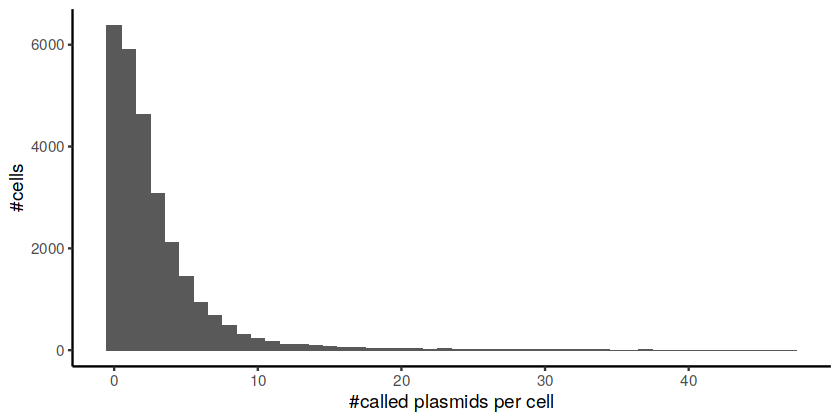

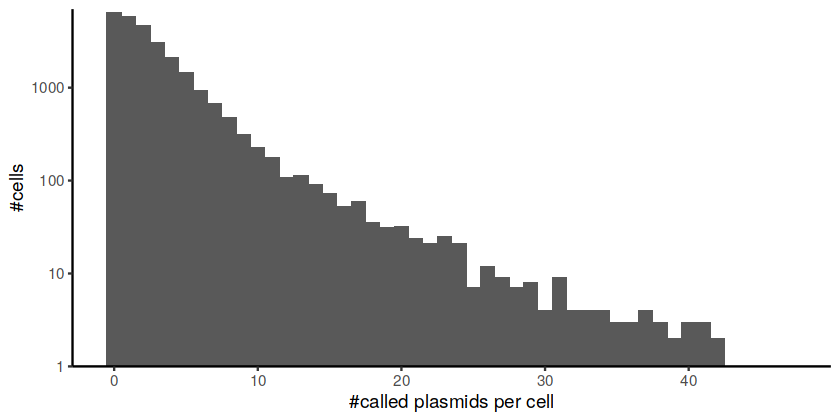

In [72]:
df_calls_all = seurat_combined@meta.data[, c('n_plasmids','n_guides')]

p5 <- ggplot(df_calls_all, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") + 
    theme_classic() 

p6 <- ggplot(df_calls_all, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    scale_y_log10(limits = c(1, 7000), expand = c(0, 0)) +
    labs(x = "#called plasmids per cell") +
    labs(y = "#cells") +
    theme_classic() 

options(repr.plot.width=7, repr.plot.height=3.5)
p5
p6

### Plot cells per plasmid distribution

In [43]:
plasmid_calls = seurat_combined@meta.data$plasmid_calls
plasmid_calls = str_split(paste0(plasmid_calls, collapse = "|"), "\\|")
df_dummy = as.data.frame(table(plasmid_calls))
df_dummy$plasmid_calls = as.character(df_dummy$plasmid_calls)
df_dummy[df_dummy$plasmid_calls == "NA", 'plasmid_calls'] = " No Plasmid"

In [44]:
head(df_dummy, 20)

,plasmid_calls,Freq
,<chr>,<int>
1,C15orf40-1,1077
2,CCCE1-1,1175
3,CCCE2-1,1071
4,CCCE3-1,967
5,CCCE4-1,802
6,CD13-1,1162
7,CD55-1,1081
8,CD73-1,1021
9,CSTB-1,1252


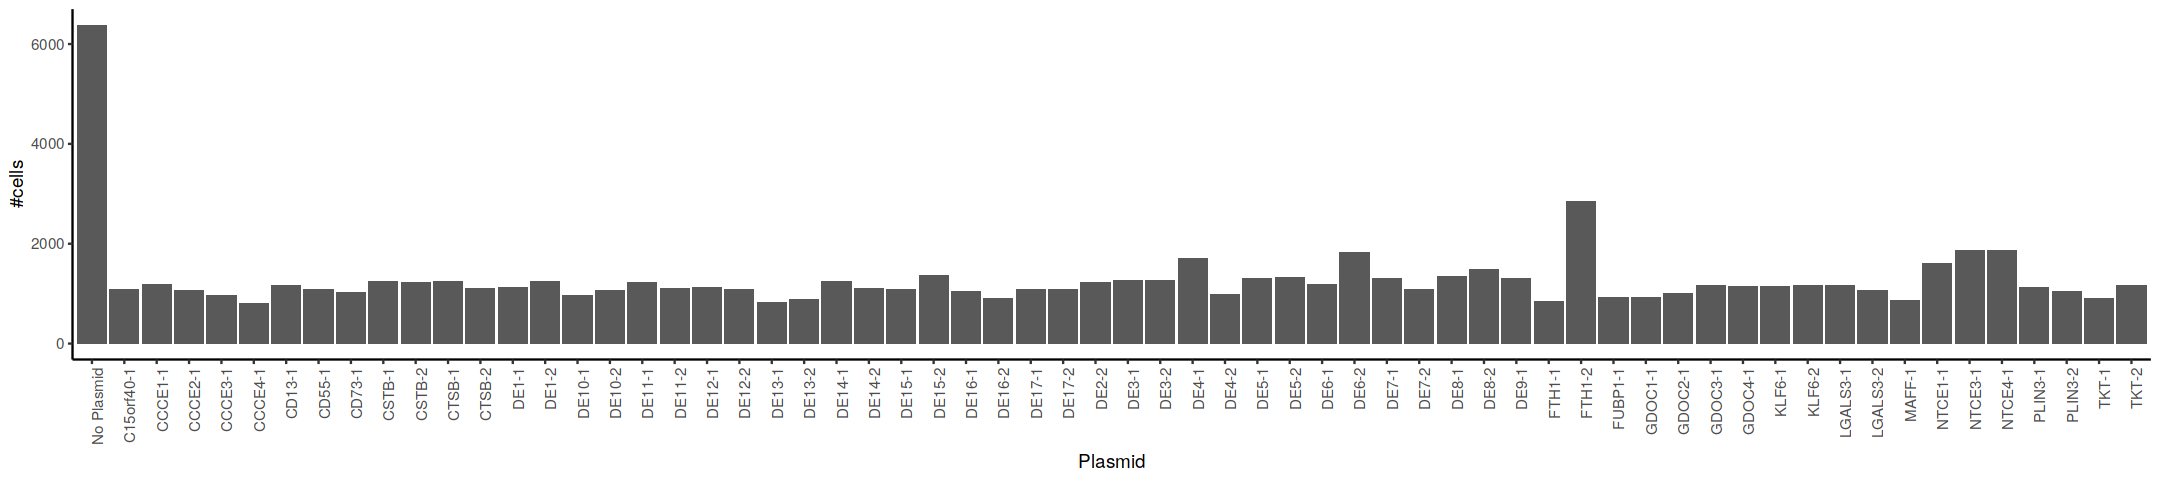

In [45]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells")
    
options(repr.plot.width=18, repr.plot.height=4)
p6

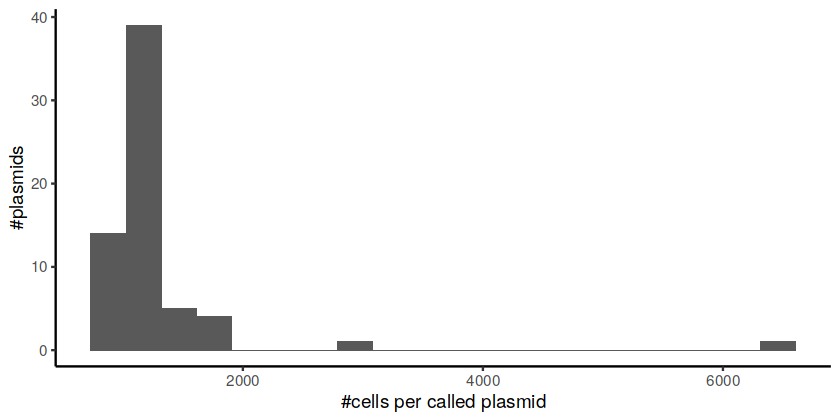

In [46]:
options(repr.plot.width=7, repr.plot.height=3.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins=20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    theme_classic() 
    

#### Eliminate no-call cells and plot again

In [47]:
df_dummy = df_dummy[df_dummy$plasmid_calls != " No Plasmid", ] 

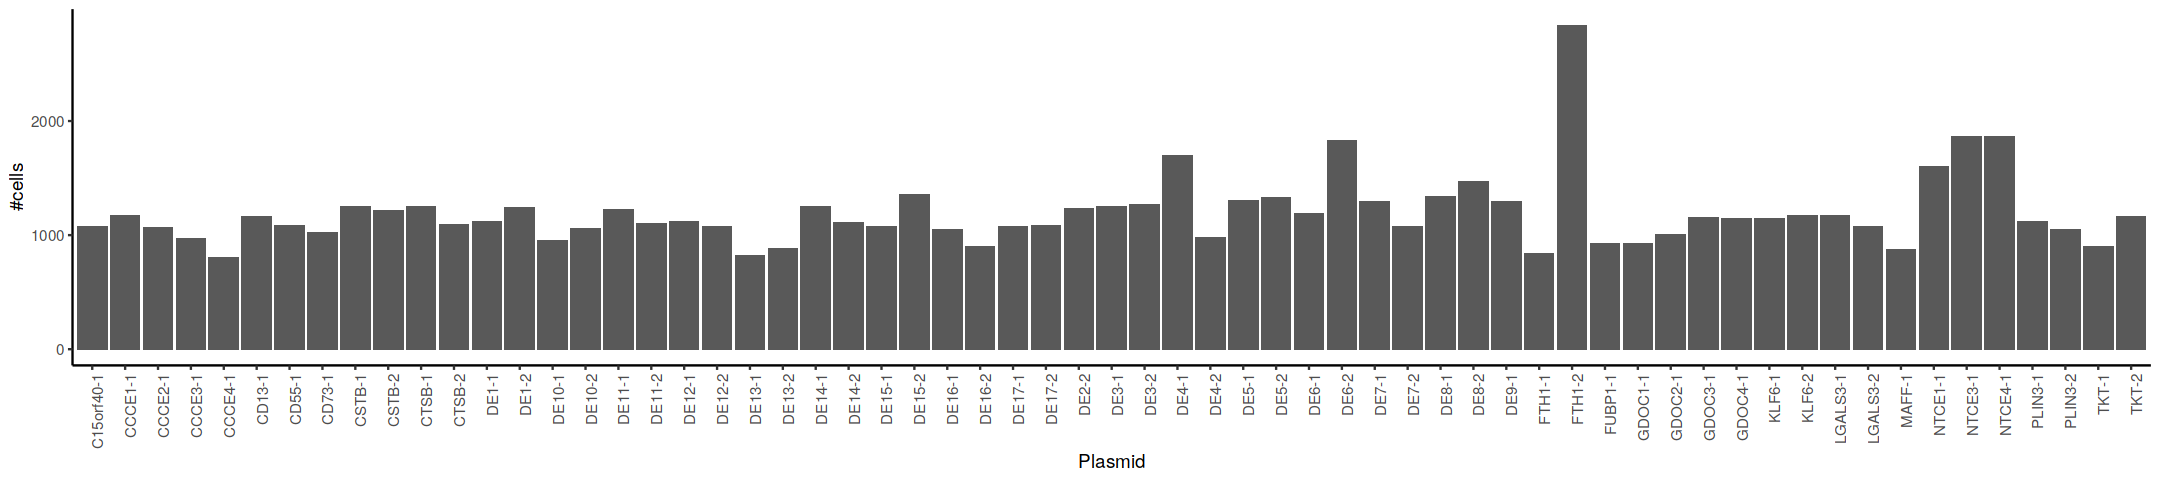

In [48]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Plasmid") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells")
    
options(repr.plot.width=18, repr.plot.height=4)
p6

Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


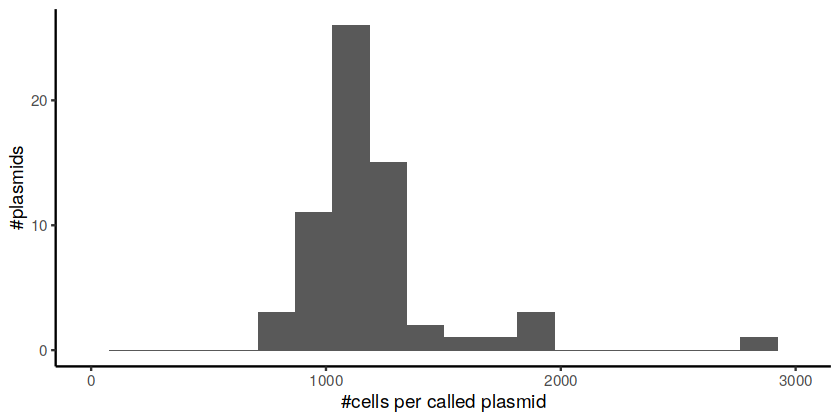

In [49]:
options(repr.plot.width=7, repr.plot.height=3.5)
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins=20) +
    labs(x = "#cells per called plasmid") +
    labs(y = "#plasmids") +
    xlim(-1,3000) +
    theme_classic() 
    

In [50]:
length(Cells(subset(seurat_combined, subset=library=='Lib_2')))

[1] 7527

# Stats

In [51]:
df_stats = seurat_combined@misc$stats
df_stats


,Cells_after_QC_filtering,Cells_recovered,Cells_with_sgRNA_count_less_than_100,Doublets_in_filtered_cells,Genes_recovered,Library,Max_mito_perc_threshold,Max_n_RNA_threshold,Max_n_genes_threshold,Min_mito_perc_threshold,Min_n_RNA_threshold,Min_n_genes_threshold,Protospacers_in_assay,Screen,Singlets_after_filtering,Singlets_perc_after_filtering,Total_doublets_before_filtering
,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>
Lib_1,8012,9169,1785,718,31847,Lib_1,17,98264,12173,3,-22058,2000,132,Screen1_66guides,7293,0.91,918
Lib_2,8565,9443,2220,1033,30856,Lib_2,18,52856,9736,3,-10516,2000,132,Screen1_66guides,7527,0.88,1168
Lib_3,6298,7113,1128,512,29531,Lib_3,17,34198,8024,3,-5058,2000,132,Screen1_66guides,5785,0.92,617
Lib_4,7201,8015,1572,665,31390,Lib_4,17,79578,11188,3,-14582,2000,132,Screen1_66guides,6536,0.91,793


# Debug

In [52]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [53]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined, df_thresholds)

In [54]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 905

[1] 905

In [55]:
length(perturbed_cells_by_guide$'DE6-1b')

[1] 905

In [56]:
nrow(seurat_combined)

[1] 29739

In [57]:
unique(seurat_combined$status)

[1] "singlet"

In [58]:
table(seurat_combined$library)


Lib_1 Lib_2 Lib_3 Lib_4 
 7293  7527  5785  6536 

In [59]:
length(perturbed_cells_by_guide$'FTH1-1a')

[1] 624

In [60]:
length(unlist(perturbed_cells_by_guide))

[1] 108950

### ---

In [61]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined_debug    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
#seurat_combined_debug    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file



In [ ]:
libraries = unique(seurat_combined_debug$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined_debug, subset = library == lib)
}
names(seurat_libs) <- libraries

In [ ]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined_debug, df_thresholds)

In [ ]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 915

[1] 915

In [ ]:
sum(rowSums(seurat_combined_debug[['sgRNA']]@counts)) - sum(rowSums(seurat_combined[['sgRNA']]@counts))

[1] 0

In [ ]:
colSums(seurat_combined_debug@meta.data != seurat_combined@meta.data)

nCount_RNA    nFeature_RNA    nCount_sgRNA  nFeature_sgRNA      nCount_SCT 
              0               0               0               0               0 
   nFeature_SCT      orig.ident         library      percent.mt          status 
              0               0               0               0               0 
          donor SCT_snn_res.0.5 seurat_clusters     guide_calls   plasmid_calls 
              0               0               0              NA              NA 
       n_guides      n_plasmids 
              0               0